# FORCE Learning in JAX

![FORCE](https://raw.githubusercontent.com/google-research/computation-thru-dynamics/master/images/FORCE_banner.png)

The original paper on FORCE learning can be found [here](https://www.sciencedirect.com/science/article/pii/S0896627309005479/pdfft?md5=15fc1e760bbc8cbf16ad0c2a10b1e5bb&pid=1-s2.0-S0896627309005479-main.pdf)

##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### Install JAX

In [0]:
!pip install --upgrade -q https://storage.googleapis.com/jax-wheels/cuda$(echo $CUDA_VERSION | sed -e 's/\.//' -e 's/\..*//')/jaxlib-0.1.8-cp36-none-linux_x86_64.whl
!pip install --upgrade -q jax

In [2]:
!python --version
!pip show jax

Python 3.6.7
Name: jax
Version: 0.1.20
Summary: Differentiate, compile, and transform Numpy code.
Home-page: https://github.com/google/jax
Author: JAX team
Author-email: jax-dev@google.com
License: Apache-2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, numpy, opt-einsum, absl-py, protobuf
Required-by: 


In [0]:
import matplotlib.pyplot as plt

from __future__ import print_function, division
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import numpy as onp

### Code for printing, running ESN and RLS

In [0]:
def keygen(key, nkeys):
  """Generate randomness that JAX can use by splitting the JAX keys.
  Args:
    key : the random.PRNGKey for JAX
    nkeys : how many keys in key generator
  Returns:
    2-tuple (new key for further generators, key generator)
  """
  keys = random.split(key, nkeys+1)
  return keys[0], (k for k in keys[1:])

In [0]:
def print_force(params, fparams, x_t, h_t, z_t, f_t, T):
  """Plot activations and outputs for the Echostate network run."""
  ntoplot = 10
  plt.figure(figsize=(16,16))

  plt.subplot(321)
  plt.plot(time, f_t + 2*onp.arange(0, f_t.shape[1]), 'g')
  plt.plot(time, z_t + 2*onp.arange(0, z_t.shape[1]), 'r');
  plt.xlim((0, T))
  plt.title('Target - f (green), Output - z (red)')
  plt.xlabel('Time')
  plt.ylabel('Dimension')

  plt.subplot(122)
  plt.imshow(h_t.T, interpolation=None)
  plt.title('Hidden activations of ESN')
  plt.xlabel('Time')
  plt.ylabel('Dimension')

  plt.subplot(323)
  plt.plot(time, h_t[:, 0:ntoplot] + 2*onp.arange(0, ntoplot), 'b')
  plt.xlim((0, T))
  plt.title('%d hidden activations of ESN'%(ntoplot))
  plt.xlabel('Time')
  plt.ylabel('Dimension')

  plt.subplot(325)
  plt.plot(time, onp.sqrt(onp.square(z_t - f_t)), 'c')
  plt.xlim((0, T))
  plt.title('Error - mean absolute error')
  plt.xlabel('Time')
  plt.ylabel('Error')

def plot_params(params):
  """Plot some of the parameters associated with the ESN."""
  plt.figure(figsize=(16,10))
  plt.subplot(221)
  plt.imshow(params['wR'] + onp.dot(params['wF'], params['wO']), 
            interpolation=None); 
  plt.colorbar()
  plt.title('Effective matrix - wR + wF wO')

  plt.subplot(222)
  if params['wO'].shape[0] == 1:
    plt.stem(params['wO'][0,:])
  else:
    plt.imshow(params['wO'], interpolation=None)
    plt.colorbar()
  plt.title('Readout weights - wO');

  x_circ = onp.linspace(-1, 1, 1000)
  y_circ = onp.sqrt(1-x_circ**2)
  evals, _ = onp.linalg.eig(params['wR'])
  plt.subplot(223)
  plt.plot(onp.real(evals), onp.imag(evals), 'o')
  plt.plot(x_circ, y_circ, 'k')
  plt.plot(x_circ, -y_circ, 'k')
  plt.axis('equal')
  plt.title('Eigenvalues of wR')

  evals, _ = onp.linalg.eig(params['wR'] + onp.dot(params['wF'], params['wO']))
  plt.subplot(224)
  plt.plot(onp.real(evals), onp.imag(evals), 'o', color='orange')
  plt.plot(x_circ, y_circ, 'k')
  plt.plot(x_circ, -y_circ, 'k')
  plt.axis('equal');
  plt.title('Eigenvalues of wR + wF wO');

In [0]:
def random_esn_params(key, u, n, m, tau=1.0, dt=0.1, g=1.0):
  """Generate random RNN parameters
  
  Arguments: 
    u: dim of the input
    n: dim of the hidden state
    m: dim of the output
    tau: "neuronal" time constant
    dt: time between Euler integration updates
    g: scaling of the recurrent matrix in the reservoir

  Returns:
    A dictionary of parameters for the ESN.
  """

  key, skeys = keygen(key, 5)
  hscale = 0.25
  ifactor = 1.0 / np.sqrt(u)
  hfactor = g / np.sqrt(n)
  pfactor = 1.0 / np.sqrt(n)
  ffactor = 1.0 # Feedback factor, keep at 1 for now.
  return {'a0' : random.normal(next(skeys), (n,)) * hscale,
          'wI' : random.normal(next(skeys), (n,u)) * ifactor,
          'wR' : random.normal(next(skeys), (n,n)) * hfactor,
          'wO' : random.normal(next(skeys), (m,n)) * pfactor,
          'wF' : random.normal(next(skeys), (n,m)) * ffactor,
          'dt_over_tau' : dt / tau}


def new_force_params(n, alpha=1.0):
  """Generate new 'parameters' for the RLS learning rule.

  This routine essentially initializes the inverse correlation matrix in RLS.

  Arguments:
    n: dim of hidden state
    alpha: initial learning rate

  Returns: 
    A dictionary with RLS parameters.
  """
  return {'P' : np.eye(n) * alpha}


def esn(x, a, h, z, wI, wR, wF, wO, dtdivtau):
  """Run the continuous-time Echostate network one step.
  
    da/dt = -a + wI x + wR h + wF z

    Arguments:
      x: ndarray of input to ESN
      a: ndarray of activations (pre nonlinearity) from prev time step
      h: ndarray of hidden states from prev time step
      z: ndarray of output from prev time step
      wI: ndarray, input matrix, shape (n, u)
      wR: ndarray, recurrent matrix, shape (n, n)
      wF: ndarray, feedback matrix, shape (n, m)
      wO: ndarray, output matrix, shape (m, n)
      dtdivtau: dt / tau

    Returns: 
      The update to the ESN at this time step.
  """
  dadt = -a + np.dot(wI, x) + np.dot(wR, h) + np.dot(wF, z)
  a = a + dtdivtau * dadt
  h = np.tanh(a)
  z = np.dot(wO, h)
  return a, h, z


def rls(h, z, f, wO, P):
  """Perform the recursive least squares step.
  
    Arguments: 
      h: ndarray of hidden state at current time step
      z: ndarray of output at current time step
      f: ndarray of targets at current time step
      wO: ndarray of output weights, shape (m, n)
      P: ndarray, inverse correlation matrix, shape (n,n)

    Returns: 
      A 2-tuple of the updated wO, and updated P
  
  """
  # update inverse correlation matrix
  k = np.expand_dims(np.dot(P, h), axis=1)
  hPh = np.dot(h.T, k)
  c = 1.0/(1.0 + hPh)
  P = P - np.dot(k*c, k.T)
    
  # update the output weights
  e = np.atleast_2d(z-f)
  dw = np.dot(-c*k, e).T
  return wO + dw, P    

### Jax implementation of FORCE learning.

In [0]:
def esn_run_and_train_jax(params, fparams, x_t, f_t=None, do_train=False):
  """Run the Echostate network forward a number of steps the length of x_t.
  
    This implementation uses JAX to build the outer time loop from basic
    Python for loop.

    Arguments: 
      params: dict of ESN params
      fparams: dict of RLS params
      x_t: ndarray of input time series, shape (t, u)
      f_t: ndarray of target time series, shape (t, m)
      do_train: Should the network be trained on this run? 
    
    Returns:
      4-tuple of params, fparams, h_t, z_t, after running ESN and potentially
        updating the readout vector.  
  """
  # per-example predictions
  a = params['a0']
  h = np.tanh(a)
  wO = params['wO']
  z = np.dot(wO, h)
  if do_train:
    P = fparams['P']
  else:
    P = None
  h_t = []
  z_t = []

  wI = params['wI']
  wR = params['wR']
  wF = params['wF']
  dtdivtau = params['dt_over_tau']
  for tidx, x in enumerate(x_t):
    a, h, z = esn(x, a, h, z, wI, wR, wF, wO, dtdivtau)
    if do_train:
      wO, P = rls(h, z, f_t[tidx], wO, P)
    h_t.append(h)
    z_t.append(z)
  
  if do_train:
    fparams['P'] = P
  params['wO'] = wO
  h_t = np.array(h_t)  
  z_t = np.array(z_t)
  return params, fparams, h_t, z_t


def esn_run_jax(params, x_t):
  """Run the echostate network forward.

    Arguments:
      params: dict of ESN params
      x_t: ndarray of input with shape (t,u)

    Returns: 
      2-tuple of ndarrays with first dim time, the hidden state and the outputs.
  """
  _, _, h_t, z_t  = esn_run_and_train_jax(params, None, x_t, 
                                          None, do_train=False)
  return h_t, z_t

esn_run_jax_jit = jit(esn_run_jax)


def esn_train_jax(params, fparams, x_t, f_t):
  """Run the echostate network forward and also train it.

    Arguments:
      params: dict of ESN params
      fparams: dict of RLS params
      x_t: ndarray of inputs with shape (t,u)
      f_t: ndarray of targets with shape (t,m)

    Returns: 
      4-tuple of updated params, fparams, and also ndarrays with first dim 
        time, the hidden state and the outputs.
  """
  return esn_run_and_train_jax(params, fparams, x_t, f_t, do_train=True)
  
esn_train_jax_jit = jit(esn_train_jax)

In [0]:
# Basic parameters of the Echostate networks
key = random.PRNGKey(0)

T = 30              # total time
u = 1               # number of inputs (didn't bother to set up zero, just put in zeros)
n = 500             # size of the reservoir in the ESN
tau = 1.0           # neuron time constant
dt = tau / 10.0     # Euler integration step
time = np.arange(0, T, dt) # all time
ntime = time.shape[0]      # the number of time steps

x_t = np.zeros((ntime,u)) # Just a stand-in in folks want a real input later

Note well, the first time jit'd functions run they take a LONG TIME because there is no jax scan function, so it's unrolling a huge graph proportional to the number of time steps!  Afterwards, it's blazingly fast.  A scan function is in the works.

Data seed: 7868221


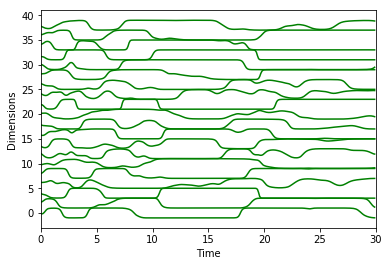

In [9]:
# Generate some target data by running an ESN, and just grabbing hidden 
# dimensions as the targets of the FORCE trained network.

g = 1.8  # Recurrent scaling of the data ESN, gives how wild the dynamics are.
m = 20   # Number of targets, and thus outputs for trained ESN.

#data_seed = onp.random.randint(0, 10000000)
data_seed = 7868221
print("Data seed: %d" % (data_seed))
key = random.PRNGKey(data_seed)
data_params = random_esn_params(key, u, n, m, g=g)
h_t, z_t = esn_run_jax_jit(data_params, x_t)

f_t = h_t[:,0:m] # This will be the training data for the trained ESN
plt.plot(time, f_t + 2*onp.arange(0, m), 'g');
plt.xlim((0, T))
plt.ylabel('Dimensions')
plt.xlabel('Time');

Params seed 7850546


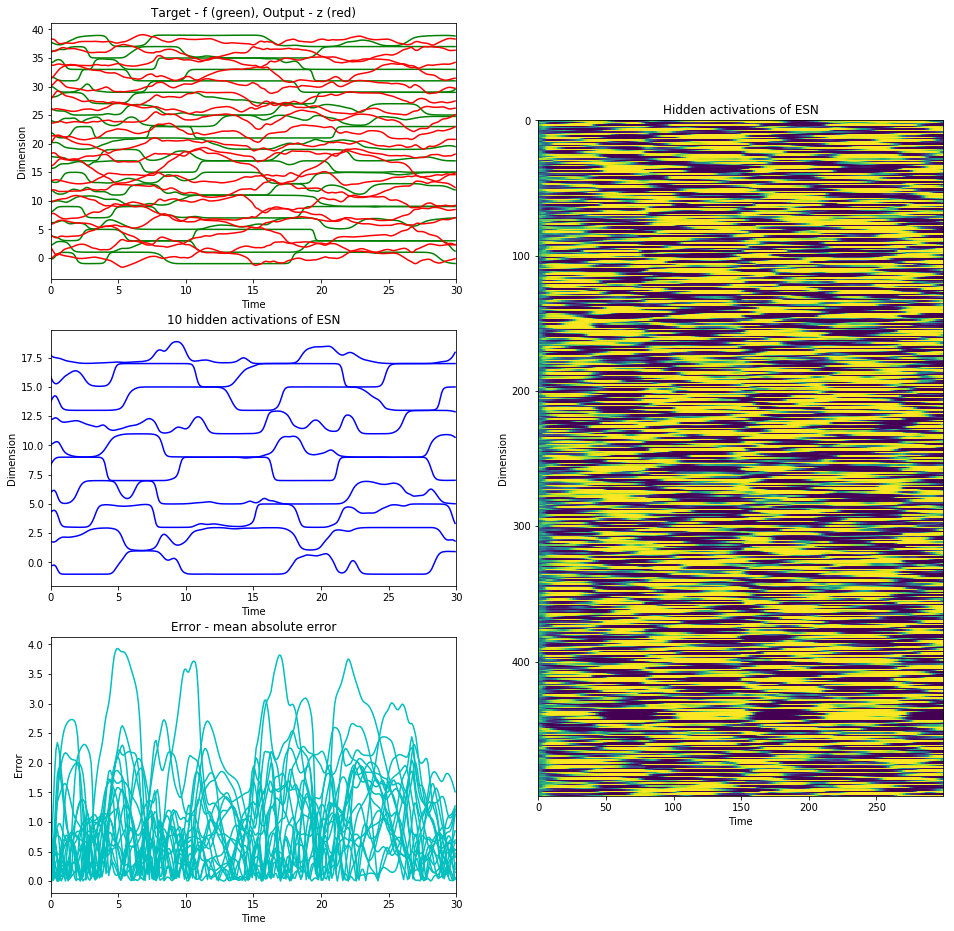

In [10]:
# Create the ESN that will trained with FORCE learning.
g = 1.5  # Lower g value was shown to be good in the paper for training.
alpha = 1e0 # Initial learning rate for RLS

params_seed = onp.random.randint(0, 10000000)
print("Params seed %d" %(params_seed))
key = random.PRNGKey(params_seed)
init_params = random_esn_params(key, u, n, m, g=g)
fparams = new_force_params(n, alpha=alpha)

# Run the untrained ESN to get a look it.
h_t, z_t = esn_run_jax_jit(init_params, x_t)
print_force(init_params, fparams, x_t, h_t, z_t, f_t, T)

In [0]:
# Copy the params to the ones we will be training.
params = dict.copy(init_params)

In [0]:
# Train the ESN, you can train all at once by setting ntraining to 
# about 15, or you can set it to 1 and watch it, by plotting in the 
# next cell.

# Again, the first time through, this takes a few minutes, afterwards
# a few tens of milliseconds.
ntraining = 15
for train_idx in range(ntraining):
  params, fparams, h_t, z_t = esn_train_jax_jit(params, fparams, x_t, f_t)

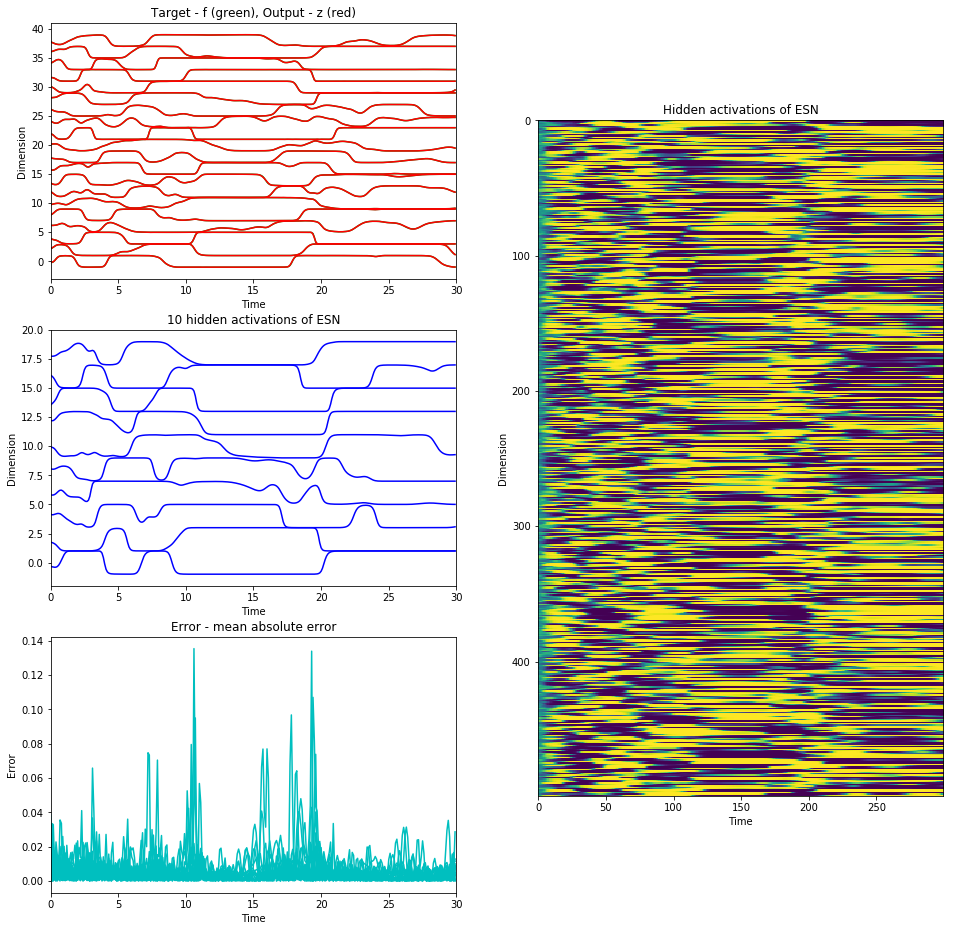

In [13]:
h_t, z_t = esn_run_jax_jit(params, x_t)
print_force(params, fparams, x_t, h_t, z_t, f_t, T)

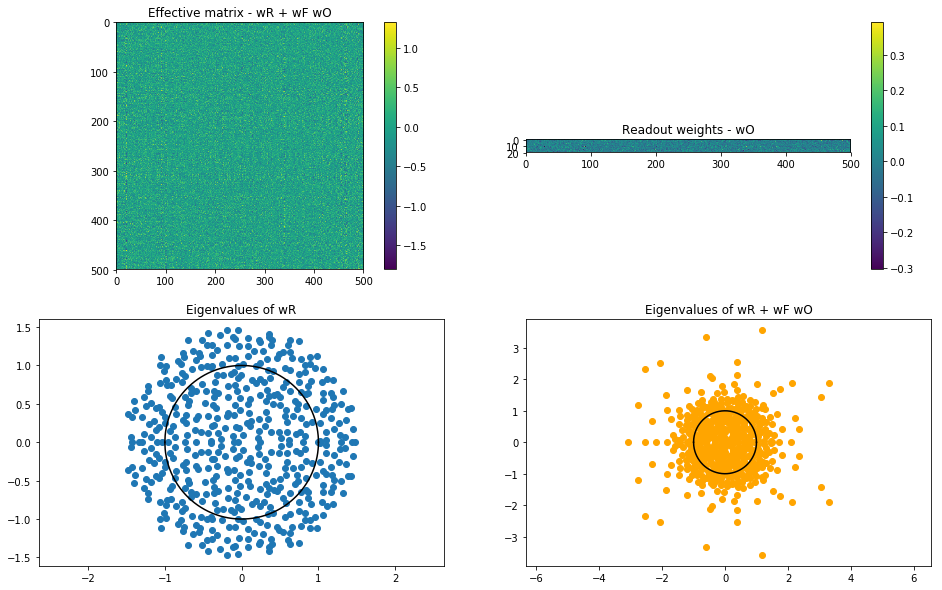

In [14]:
plot_params(params)

In [15]:
# Let's do a little timing. Here are the speeds of the routines *without* 
# just-in-time compilation.
%timeit esn_run_jax(params, x_t)
%timeit esn_train_jax(params, fparams, x_t, f_t)

The slowest run took 35.27 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 718 ms per loop
The slowest run took 13.15 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 2.01 s per loop


In [16]:
# Here are the speeds of the routines with just-in-time compilation.
%timeit esn_run_jax_jit(params, x_t)
%timeit esn_train_jax_jit(params, fparams, x_t, f_t)

10 loops, best of 3: 30.8 ms per loop
10 loops, best of 3: 51.4 ms per loop


### LAX implementation of FORCE learning.
Let's dig into the APIs a little more to see if we 
can avoid some of this JIT compile time to really long unrolled recurrent graphs.  Keep in mind that using these LAX functions will not track gradients, whereas the JAX layer will.  We get away with this because we already have the closed form solution to the FORCE learning problem (recursive least squares (RLS)) and thus do not need gradients.

In [0]:
from jax import lax

In [0]:
def esn_run_and_train_lax(params, fparams, x_t, f_t=None, do_train=False):
  """Run the Echostate network ntime steps, where ntime is shape[0] of x_t.
  
    This implementation uses LAX to build the outer time loop the LAX 
      fori_loop and dynamic_update_slice functions.

    Arguments: 
      params: dict of ESN params
      fparams: dict of RLS params
      x_t: ndarray of input time series, shape (t, u)
      f_t: ndarray of target time series, shape (t, m)
      do_train: Should the network be trained on this run? 
    
    Returns:
      4-tuple of params, fparams, h_t, z_t, after running ESN and potentially
        updating the readout vector.  
  """
  ntime = x_t.shape[0]
  a0 = params['a0']
  a_t = np.zeros((ntime+1, n))
  z_t = np.zeros((ntime, m))
  a_t = lax.dynamic_update_slice(a_t, np.expand_dims(a0, 0), [0, 0])

  wI = params['wI']
  wR = params['wR']
  wF = params['wF']
  dtdivtau = params['dt_over_tau']

  def esn_body(tidx, inputs):
    a_t, z_t, wO, P = inputs
    x = x_t[tidx]
    a = a_t[tidx]
    z = z_t[tidx]
    a, h, z = esn(x, a, np.tanh(a), z, wI, wR, wF, wO, dtdivtau)
   
    if do_train:
      f = f_t[tidx]
      wO, P = rls(h, z, f, wO, P)

    a_t = lax.dynamic_update_slice(a_t, np.expand_dims(a, 0), [tidx+1, 0])
    z_t = lax.dynamic_update_slice(z_t, np.expand_dims(z, 0), [tidx, 0])  
    return a_t, z_t, wO, P

  P = fparams['P'] if do_train else None
  a_t, z_t, wO, P = lax.fori_loop(0, ntime, esn_body, 
                                 (a_t, z_t, params['wO'], P))
  h_t = np.tanh(a_t[1:]) # ditch initial condition

  if do_train:
    params['wO'] = wO
    fparams['P'] = P

  return params, fparams, h_t, z_t
   

def esn_run_lax(params, x_t):
  """Run the echostate network forward.

    Arguments:
      params: dict of ESN params
      x_t: ndarray of input with shape (t,u)

    Returns: 
      2-tuple of ndarrays with first dim time, the hidden state and the outputs.
  """
  _, _, h_t, z_t  = esn_run_and_train_lax(params, None, x_t, 
                                          None, do_train=False)
  return h_t, z_t

esn_run_lax_jit = jit(esn_run_lax)


def esn_train_lax(params, fparams, x_t, f_t):
  """Run the echostate network forward and also train it.

    Arguments:
      params: dict of ESN params
      fparams: dict of RLS params
      x_t: ndarray of inputs with shape (t,u)
      f_t: ndarray of targets with shape (t,m)

    Returns: 
      4-tuple of updated params, fparams, and also ndarrays with first dim 
        time, the hidden state and the outputs.
  """
  return esn_run_and_train_lax(params, fparams, x_t, f_t, do_train=True)
  
esn_train_lax_jit = jit(esn_train_lax)

In [0]:
# Basic parameters of the Echostate networks
key = random.PRNGKey(0)
T = 30              # total time
u = 1               # number of inputs (didn't bother to set up zero, use zeros)
n = 500             # size of the reservoir in the ESN
tau = 1.0           # neuron time constant
dt = tau / 10.0     # Euler integration step
time = np.arange(0, T, dt) # all time
ntime = time.shape[0]      # the number of time steps

Data seed: 7868221


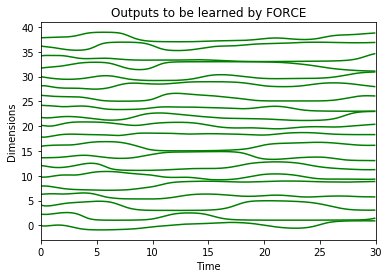

In [20]:
# Generate some target data by running an ESN, and just grabbing hidden 
# dimensions as the targets of the FORCE trained network.

g = 1.8  # Recurrent scaling of the data ESN, gives how wild the dynamics are.
m = 20   # Number of targets, and thus outputs for trained ESN.

#data_seed = onp.random.randint(0, 10000000)
data_seed = 7868221
print("Data seed: %d" % (data_seed))
key = random.PRNGKey(data_seed)
data_params = random_esn_params(key, u, n, m, g=g)

h_t, z_t = esn_run_lax_jit(data_params, x_t)

f_t = h_t[:,0:m] # This will be the training data for the trained ESN
plt.plot(time, f_t + 2*onp.arange(0, m), 'g');
plt.xlim((0, T))
plt.ylabel('Dimensions')
plt.xlabel('Time');
plt.title('Outputs to be learned by FORCE');

Params seed 3288863


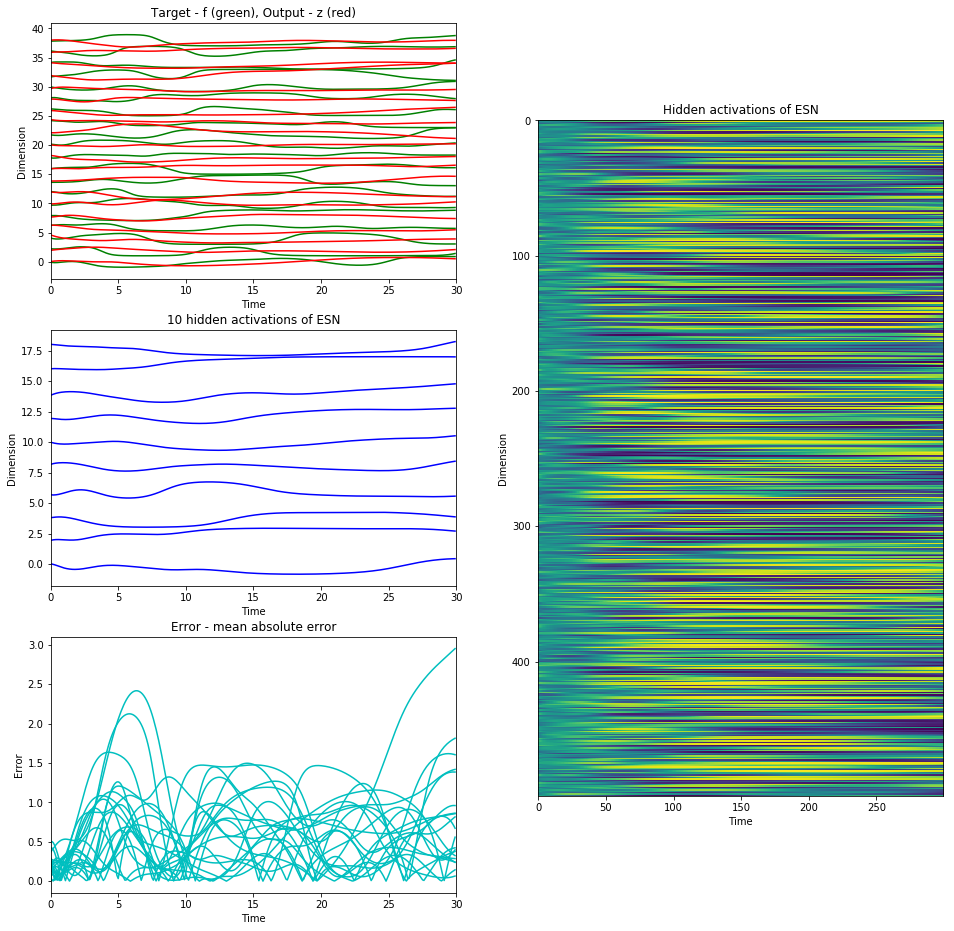

In [21]:
# Create the ESN that will trained with FORCE learning.
g = 1.5  # Lower g value was shown to be good in the paper for training.
alpha = 1e0 # Initial learning rate for RLS

params_seed = onp.random.randint(0, 10000000)
print("Params seed %d" %(params_seed))
key = random.PRNGKey(params_seed)
init_params = random_esn_params(key, u, n, m, g=g)
fparams = new_force_params(n, alpha=alpha)

# Run the untrained ESN to get a look it.
h_t, z_t = esn_run_lax_jit(init_params, x_t)
print_force(init_params, fparams, x_t, h_t, z_t, f_t, T)

In [0]:
# Copy the params to the ones we will be training.
params = dict.copy(init_params)

In [0]:
# Train the ESN, you can train all at once by setting ntraining to 
# about 15, or you can set it to 1 and watch it, by plotting in the 
# next cell.
ntraining = 15
for train_idx in range(ntraining):
  params, fparams, h_t, z_t = esn_train_lax_jit(params, fparams, x_t, f_t)

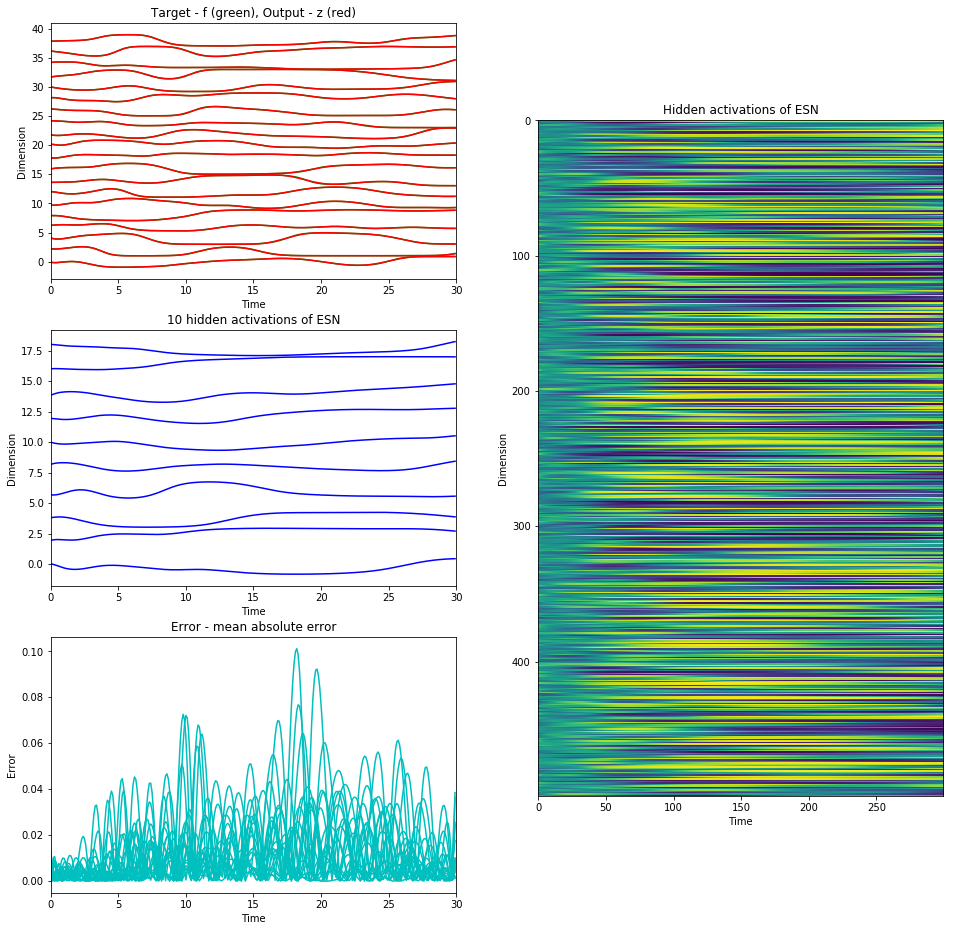

In [24]:
h_t, z_t = esn_run_lax_jit(params, x_t)
print_force(params, fparams, x_t, h_t, z_t, f_t, T)

In [25]:
# Let's do a little timing. Here are the speeds of the routines without 
# just-in-time compilation.
%timeit esn_run_lax(params, x_t)
%timeit esn_train_lax(params, fparams, x_t, f_t)

1 loop, best of 3: 262 ms per loop
1 loop, best of 3: 518 ms per loop


In [26]:
# Here are the speeds of the routines with just-in-time compilation.
%timeit esn_run_lax_jit(params, x_t)
%timeit esn_train_lax_jit(params, fparams, x_t, f_t)

10 loops, best of 3: 92.3 ms per loop
10 loops, best of 3: 129 ms per loop


In [0]:
# Compared to ~35ms and ~50ms for jit'd jax above.